### This file contains quality check on the original dtseries, it contains: 
#### tSNR: temporal signal-to-noise ratio
#### CNR: contrast-to-noise ratio
#### FD: Framewise displacement
#### Mean time course in different ROI


In [1]:
import nibabel as nib
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.io as sio
import time, os, pickle, json
import matplotlib.pyplot as plt
import matplotlib as mpl
from os.path import join as pjoin
from sklearn.preprocessing import StandardScaler

def roi_mask(roi_name):
    """
        roi_name : list or str
    """
    # load reference info
    main_path = '/nfs/z1/zhenlab/BrainImageNet/Analysis_results/'
    roi_name_path = pjoin(main_path, 'roilbl_mmp.csv')
    roi_names = pd.read_csv(roi_name_path)
    roi = sio.loadmat(pjoin(main_path, 'MMP_mpmLR32k.mat'))['glasser_MMP']  # 1x59412

    # start load name
    roi_index = []
    if isinstance(roi_name, str):
        roi_tmp_index = roi_names.loc[roi_names.isin([f'L_{roi_name}_ROI']).any(axis=1)].index[0]+1
        roi_index.extend([roi_tmp_index, roi_tmp_index+180])
        mask = np.asarray([True if x in roi_index else False for x in roi[0]])
    else:
        for name in roi_name:
            roi_tmp_index = roi_names.loc[roi_names.isin([f'L_{name}_ROI']).any(axis=1)].index[0]+1
            roi_index.extend([roi_tmp_index, roi_tmp_index+180])
        mask = np.asarray([True if x in roi_index else False for x in roi[0]])
    return mask
    
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams.update({'font.size': 12, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

##### tSNR across subjects

In [2]:
# generate surface map for tSNR
def save_ciftifile(data, filename):
    template = '/nfs/z1/zhenlab/BrainImageNet/NaturalObject/data/bold/Analysis_derivatives/ciftify/sub-core02/MNINonLinear/Results/ses-ImageNet01_task-object_run-1/ses-ImageNet01_task-object_run-1_Atlas.dtseries.nii'
    ex_cii = nib.load(template)
    if len(data.shape) > 1:
        ex_cii.header.get_index_map(0).number_of_series_points = data.shape[0]
    else:
        ex_cii.header.get_index_map(0).number_of_series_points = 1
        data = data[np.newaxis, :]
    nib.save(nib.Cifti2Image(data.astype(np.float32), ex_cii.header), filename)
    
def tsnr(data):
    mean = data.mean(axis=-1)
    std = data.std(axis=-1)
    return np.nan_to_num(mean/std)

ses-action01_task-action_run-1 in sub-01
ses-action01_task-action_run-10 in sub-01
ses-action01_task-action_run-11 in sub-01
ses-action01_task-action_run-12 in sub-01
ses-action01_task-action_run-2 in sub-01
ses-action01_task-action_run-3 in sub-01
ses-action01_task-action_run-4 in sub-01
ses-action01_task-action_run-5 in sub-01
ses-action01_task-action_run-6 in sub-01
ses-action01_task-action_run-7 in sub-01
ses-action01_task-action_run-8 in sub-01
ses-action01_task-action_run-9 in sub-01
ses-action01_task-action_run-1 in sub-02
ses-action01_task-action_run-10 in sub-02
ses-action01_task-action_run-11 in sub-02
ses-action01_task-action_run-12 in sub-02
ses-action01_task-action_run-2 in sub-02
ses-action01_task-action_run-3 in sub-02
ses-action01_task-action_run-4 in sub-02
ses-action01_task-action_run-5 in sub-02
ses-action01_task-action_run-6 in sub-02
ses-action01_task-action_run-7 in sub-02
ses-action01_task-action_run-8 in sub-02
ses-action01_task-action_run-9 in sub-02
ses-action

<ipython-input-2-f2a45914d1fe>:15: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(mean/std)


ses-action01_task-action_run-1 in sub-05
ses-action01_task-action_run-10 in sub-05
ses-action01_task-action_run-11 in sub-05
ses-action01_task-action_run-12 in sub-05
ses-action01_task-action_run-2 in sub-05
ses-action01_task-action_run-3 in sub-05
ses-action01_task-action_run-4 in sub-05
ses-action01_task-action_run-5 in sub-05
ses-action01_task-action_run-6 in sub-05
ses-action01_task-action_run-7 in sub-05
ses-action01_task-action_run-8 in sub-05
ses-action01_task-action_run-9 in sub-05
ses-action01_task-action_run-1 in sub-06
ses-action01_task-action_run-10 in sub-06
ses-action01_task-action_run-11 in sub-06
ses-action01_task-action_run-12 in sub-06
ses-action01_task-action_run-2 in sub-06
ses-action01_task-action_run-3 in sub-06
ses-action01_task-action_run-4 in sub-06
ses-action01_task-action_run-5 in sub-06
ses-action01_task-action_run-6 in sub-06
ses-action01_task-action_run-7 in sub-06
ses-action01_task-action_run-8 in sub-06
ses-action01_task-action_run-9 in sub-06
ses-action

<ipython-input-3-2cbc7707b49b>:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_yticklabels(fig.get_yticks().astype(int), size = 15)


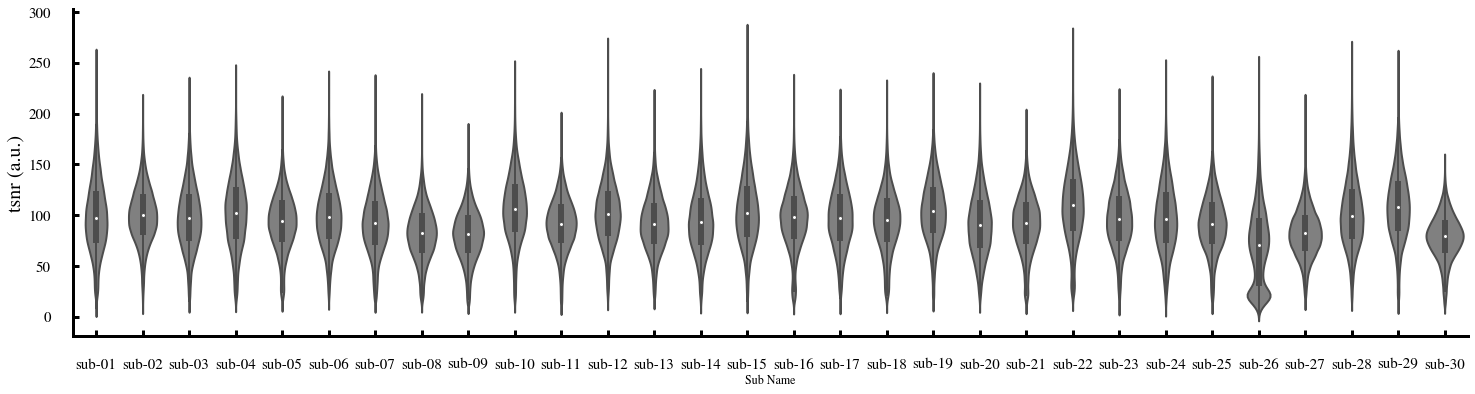

In [3]:
def get_time_series(sub_name, ciftify_dir, result_dir, n_run, roi_mat = None):

    # MNINolinear/Results disposit all the runs data
    _result_path = pjoin(ciftify_dir, sub_name, result_dir)
    # extract the action runs
    task = 'action' 
    data_runs = [_ for _ in os.listdir(_result_path) if ('action' in _) and (task in _) \
                    and ('discard' not in _) and int(_.split('-')[-1].split('_')[0])<=12]
    data_runs.sort() # sort() to be [1 10 11 12 2 -- 9]
    # initialize the mapping dict
    stim_resp_map = {}
    # loop run
    for single_run in data_runs[:n_run]:
        print(single_run + ' in ' + sub_name)
        # prepare .feat/GrayordinatesStats dir
        nii_dir = '{0}'.format(single_run)
        nii_path = pjoin(ciftify_dir, sub_name, result_dir, nii_dir)
        # loop trial 
        nii_file = pjoin(nii_path, '{0}_Atlas.dtseries.nii'.format(single_run))
        dt_data = nib.load(nii_file).get_fdata()
        if roi_mat:
            # only save roi
            stim_resp_map[single_run] = np.array(dt_data[:,roi_mat])
        else:
            stim_resp_map[single_run] = np.array(dt_data)
    # transfer to matrix
    time_series = np.dstack(tuple([stim_resp_map[_] for _ in list(stim_resp_map.keys())]))
    time_series = time_series.transpose((2,1,0)).astype(np.float32)
    return time_series
    
# load data
ciftify_dir = '/nfs/z1/userhome/ZhouMing/workingdir/BIN/action/data/bold/derivatives/ciftify'
result_dir = 'MNINonLinear/Results/'
beta_path = '/nfs/z1/zhenlab/BrainImageNet/action/data/bold/derivatives/beta'

n_run = 12
sub_names = sorted([i for i in os.listdir(beta_path) if i.startswith('sub-')]) 
# Violin plot of the tsnr distribution
df = pd.DataFrame()
tsnr_mean = np.zeros(1)

for sub_name in sub_names:
    # handle special subject
    tsnr_sub_path = pjoin(beta_path, sub_name, f'{sub_name}_action-tsnr.npy')
    if not os.path.exists(tsnr_sub_path):
        dtseries_sum = get_time_series(sub_name, ciftify_dir, result_dir, n_run)
        tsnr_sum = np.zeros_like(dtseries_sum[:,:,0])
        n_run = dtseries_sum.shape[0]   
        for run in range(n_run):
            run_data = dtseries_sum[run,:,:]
            tsnr_sum[run, :] = tsnr(run_data)
        tsnr_sub = tsnr_sum.mean(axis=0)
        np.save(tsnr_sub_path, tsnr_sub)
    else:
        tsnr_sub = np.load(tsnr_sub_path)
    # concatenate data
    tsnr_mean = np.concatenate((tsnr_mean, tsnr_sub[:59412]), axis=0)
# delete first value
tsnr_mean = np.delete(tsnr_mean, 0, axis=0).astype(np.float32)
label = np.repeat(sub_names, 59412)
# merge data and label into df
df['tsnr (a.u.)'] = tsnr_mean
df['Sub Name'] = label
plt.figure(figsize=(25, 6))

fig = sns.violinplot(x="Sub Name", y="tsnr (a.u.)", data=df, color='grey', linewidth=2)
fig.set_yticklabels(fig.get_yticks().astype(int), size = 15)
ax = plt.gca()

ax.tick_params(labelsize=15, width=3, length=6, direction="in", pad=22)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
plt.ylabel("tsnr (a.u.)", size = 20)

# save tsnr map
beta_path = '/nfs/z1/zhenlab/BrainImageNet/action/data/bold/derivatives/beta'
result_path = '/nfs/z1/userhome/ZhouMing/workingdir/BIN/action/utils/data_paper/result'

sub_names = sorted([i for i in os.listdir(beta_path) if i.startswith('sub-')]) 
tsnr_merge = np.zeros((30, 91282))
for idx,sub_name in enumerate(sub_names):
    tsnr_merge[idx] = np.load(pjoin(beta_path, sub_name, f'{sub_name}_action-tsnr.npy'))
tsnr_map = tsnr_merge.mean(axis=0)
save_ciftifile(tsnr_map, pjoin(result_path, 'tsnr_map_action.dtseries.nii'))


#### FD across subjects

In [5]:
import re

fmriprep_path = '/nfs/z1/userhome/ZhouMing/workingdir/BIN/action/data/bold/derivatives/fmriprep'
mot_params = ['trans_x','trans_y','trans_z','rot_x','rot_y','rot_z']
sub_dirs = [ _ for _ in os.listdir(fmriprep_path) if 'sub' in _ and '.' not in _ ]
sub_dirs.sort()

flag = 'action'
# index quota required
quota = np.nanmedian
FD_sum = np.zeros((1))

for sub_dir in sub_dirs:
    ses_dirs = [_ for _ in os.listdir(pjoin(fmriprep_path, sub_dir)) if flag in _ and int(_[-2:])<2]
    ses_dirs.sort()
    for ses_dir in ses_dirs:
        files = [ _ for _ in os.listdir(pjoin(fmriprep_path, sub_dir, ses_dir, 'func')) if 'desc-confounds_timeseries.tsv' in _ \
                 and int(re.findall(r'run-\d+', _)[0].split('-')[-1])<=12]
        files.sort()
        for file in files:
            df = pd.read_csv(pjoin(fmriprep_path,f'{sub_dir}/{ses_dir}/func/{file}'), sep='\t')
            FD = np.sum(tuple([np.abs(df[_].values) for _ in mot_params]), axis=0)
            FD_index = np.array(quota(FD))[np.newaxis]
            # concatenate data
            FD_sum = np.concatenate((FD_sum, FD_index), axis=0)
    print(f'Finish {sub_dir} with {len(files)} runs')

# delete first value
FD_sum = np.delete(FD_sum, 0, axis=0).astype(np.float32)
label = np.repeat(sub_dirs, len(files))

Finish sub-01 with 12 runs
Finish sub-02 with 12 runs
Finish sub-03 with 12 runs
Finish sub-04 with 12 runs
Finish sub-05 with 12 runs
Finish sub-06 with 12 runs
Finish sub-07 with 12 runs
Finish sub-08 with 12 runs
Finish sub-09 with 12 runs
Finish sub-10 with 12 runs
Finish sub-11 with 12 runs
Finish sub-12 with 12 runs
Finish sub-13 with 12 runs
Finish sub-14 with 12 runs
Finish sub-15 with 12 runs
Finish sub-16 with 12 runs
Finish sub-17 with 12 runs
Finish sub-18 with 12 runs
Finish sub-19 with 12 runs
Finish sub-20 with 12 runs
Finish sub-21 with 12 runs
Finish sub-22 with 12 runs
Finish sub-23 with 12 runs
Finish sub-24 with 12 runs
Finish sub-25 with 12 runs
Finish sub-26 with 12 runs
Finish sub-27 with 12 runs
Finish sub-28 with 12 runs
Finish sub-29 with 12 runs
Finish sub-30 with 12 runs


Text(0.5, 0, 'Sub Name')

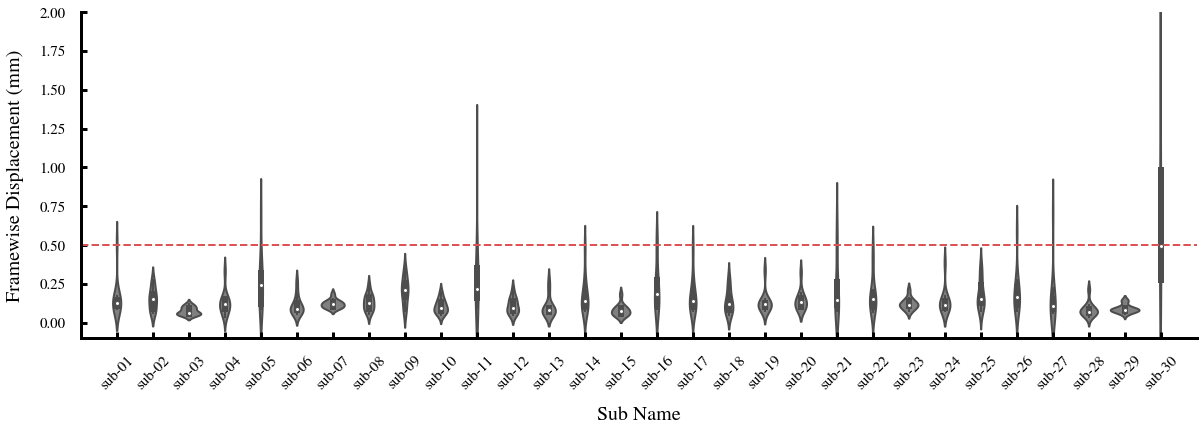

In [23]:

# merge data and label into df
df_FD = pd.DataFrame()
df_FD['FD'] = FD_sum
df_FD['Sub Name'] = label
plt.figure(figsize=(20, 6))

fig = sns.violinplot(x="Sub Name", y="FD", data=df_FD, color='grey', linewidth=2)
# fig.set_yticklabels(fig.get_yticks(), size = 15)
ax = plt.gca()
ax.set_ylim(-0.1, 2)
ax.set_xlim(-1,30)
ax.plot([-1,30], [0.5, 0.5], ls='--',color='#DD5353',lw=2)

ax.tick_params(labelsize=15, width=3, length=6, direction="in", pad=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
plt.xticks(rotation=45)
plt.ylabel("Framewise Displacement (mm)", size=20, labelpad=15)
plt.xlabel("Sub Name", size=20, labelpad=15)

#### Plot time course based on percent signal change

In [4]:
# prepare ROI info
def save_ciftifile(data, filename):
    template = '/nfs/z1/zhenlab/BrainImageNet/NaturalObject/data/bold/Analysis_derivatives/ciftify/sub-core02/MNINonLinear/Results/ses-ImageNet01_task-object_run-1/ses-ImageNet01_task-object_run-1_Atlas.dtseries.nii'
    ex_cii = nib.load(template)
    ex_cii.header.get_index_map(0).number_of_series_points = data.shape[0]
    nib.save(nib.Cifti2Image(data.astype(np.float32), ex_cii.header), filename)

def roi_mask(roi_name):
    """
        roi_name : list or str
    """
    # load reference info
    main_path = '/nfs/z1/zhenlab/BrainImageNet/Analysis_results/'
    roi_name_path = pjoin(main_path, 'roilbl_mmp.csv')
    roi_names = pd.read_csv(roi_name_path)
    roi = sio.loadmat(pjoin(main_path, 'MMP_mpmLR32k.mat'))['glasser_MMP']  # 1x59412

    # start load name
    roi_index = []
    if isinstance(roi_name, str):
        roi_tmp_index = roi_names.loc[roi_names.isin([f'L_{roi_name}_ROI']).any(axis=1)].index[0]+1
        roi_index.extend([roi_tmp_index, roi_tmp_index+180])
        mask = np.asarray([True if x in roi_index else False for x in roi[0]])
    else:
        for name in roi_name:
            roi_tmp_index = roi_names.loc[roi_names.isin([f'L_{name}_ROI']).any(axis=1)].index[0]+1
            roi_index.extend([roi_tmp_index, roi_tmp_index+180])
        mask = np.asarray([True if x in roi_index else False for x in roi[0]])
    return mask

# define path
main_path = '/nfs/z1/zhenlab/BrainImageNet/Analysis_results/'
roi_path = pjoin(main_path, 'MMP_mpmLR32k.mat')
roi_name_path = pjoin(main_path, 'roilbl_mmp.csv')
network_path = '/nfs/z1/atlas/ColeAnticevicNetPartition/cortex_parcel_network_assignments.mat'
roi_correspond = sio.loadmat(roi_path)['glasser_MMP']
roi_names = pd.read_csv(roi_name_path)
network = sio.loadmat(network_path)['netassignments'] 
network = [x[0] for x in network]

Ventral_name = ['V8', 'PIT', 'FFC', 'VVC', 'VMV1', 'VMV2', 'VMV3']
Dorsal_name = ['V3A', 'V3B', 'V6', 'V6A', 'V7', 'IPS1', 'V3CD', 'V4t', 'LO1', 'LO2', 'LO3', 'FST', 'MST', 'MT', 'PH']

roi_sum = ['Ventral', 'Dorsal']
for roi in roi_sum:
    exec(f'{roi}_mask = roi_mask({roi}_name)')
    print(eval(f'{roi}_mask').sum())

select_network = [8] 
roi_index = [idx+1 for idx,x in enumerate(network) if x in select_network]
Auditory_mask = np.asarray([True if x in roi_index else False for x in roi_correspond[0]])
print(Auditory_mask.sum())

1244
2489
1664


In [69]:
def get_time_course(sub_name):

    # define paths
    ciftify_dir = '/nfs/z1/userhome/ZhouMing/workingdir/BIN/action/data/bold/derivatives/ciftify'
    result_dir = 'MNINonLinear/Results/'
    # MNINolinear/Results disposit all the runs data
    _result_path = pjoin(ciftify_dir, sub_name, result_dir)
    # extract the action runs
    task = 'action' 
    data_runs = [_ for _ in os.listdir(_result_path) if ('action' in _) and (task in _) \
                    and ('discard' not in _) and int(_.split('-')[-1].split('_')[0])<=12]
    data_runs.sort() # sort() to be [1 10 11 12 2 -- 9]
    # initialize the mapping dict
    time_course = np.zeros((len(data_runs), 144, 59412))
    # loop run
    for run_idx, single_run in enumerate(data_runs):
        print(single_run + ' in ' + sub_name)
        # prepare .feat/GrayordinatesStats dir
        nii_dir = '{0}'.format(single_run)
        nii_path = pjoin(ciftify_dir, sub_name, result_dir, nii_dir)
        # loop trial 
        nii_file = pjoin(nii_path, '{0}_Atlas.dtseries.nii'.format(single_run))
        dt_data = nib.load(nii_file).get_fdata()[:, :59412]
        # scale data
        # scaler = StandardScaler()
        # dt_data = scaler.fit_transform(dt_data)
        # locate the stimulus onset period and compute its mean form
        # In a block, stimulus present 2s and offset 2s, with 5 stimulus presenting like this, 
        # followed with a 4s blank. We will average the stimulus presenting period
        stim_time_course = dt_data[6:-6, :]
        # task_condition = stim_time_course.mean(axis=0)[2:].reshape(5, 2, 59412).mean(axis=0)
        base_condition = dt_data[:6, :].mean(axis=0)
        # compute signal change: between the baseline condition (B) and the task condition (T)
        # percent signal change = (T-B)/B×100%
        time_course[run_idx] = (stim_time_course - base_condition) / base_condition * 100
        # (task_condition - base_condition) / base_condition * 100
    return time_course.mean(axis=0)
    
# load data
beta_path = '/nfs/z1/zhenlab/BrainImageNet/action/data/bold/derivatives/beta'
sub_names = sorted([i for i in os.listdir(beta_path) if i.startswith('sub-') and int(i.split('-')[-1])<=30]) 

time_course_sum = np.zeros((len(sub_names), 144, 59412))
for sub_idx, sub_name in enumerate(sub_names):
    time_course_sum[sub_idx] = get_time_course(sub_name)

# # compute mean and std across subjects
# time_course_info = np.zeros((2, 144, 59412))
# time_course_info[0] = time_course_sum.mean(axis=0)
# time_course_info[1] = time_course_sum.std(axis=0)


ses-action01_task-action_run-1 in sub-01
ses-action01_task-action_run-10 in sub-01
ses-action01_task-action_run-11 in sub-01
ses-action01_task-action_run-12 in sub-01
ses-action01_task-action_run-2 in sub-01
ses-action01_task-action_run-3 in sub-01
ses-action01_task-action_run-4 in sub-01
ses-action01_task-action_run-5 in sub-01
ses-action01_task-action_run-6 in sub-01
ses-action01_task-action_run-7 in sub-01
ses-action01_task-action_run-8 in sub-01
ses-action01_task-action_run-9 in sub-01
ses-action01_task-action_run-1 in sub-02
ses-action01_task-action_run-10 in sub-02
ses-action01_task-action_run-11 in sub-02
ses-action01_task-action_run-12 in sub-02
ses-action01_task-action_run-2 in sub-02
ses-action01_task-action_run-3 in sub-02
ses-action01_task-action_run-4 in sub-02
ses-action01_task-action_run-5 in sub-02
ses-action01_task-action_run-6 in sub-02
ses-action01_task-action_run-7 in sub-02
ses-action01_task-action_run-8 in sub-02
ses-action01_task-action_run-9 in sub-02
ses-action

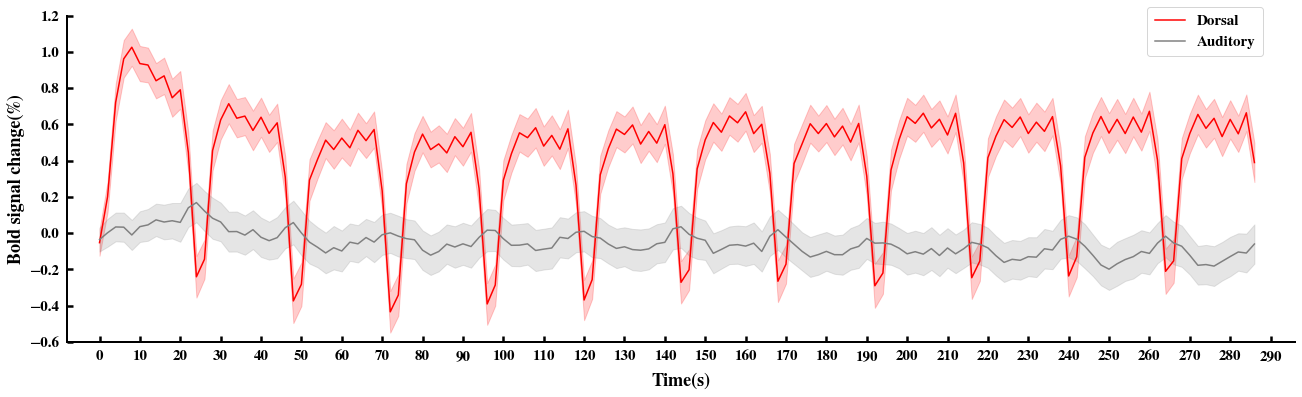

In [80]:
roi_sum = ['Dorsal', 'Auditory']

colors = ['red', 'grey']
plt.figure(figsize=(22, 6))
n_time_point = time_course_info.shape[1]

for roi_idx, roi in enumerate(roi_sum):
    time_course_roi = time_course_sum[:, :, eval(f'{roi}_mask')].mean(axis=-1)
    time_course_mean = time_course_roi.mean(axis=0)
    time_course_std = np.sqrt(time_course_roi.std(axis=0)/(len(sub_names)))
    # plot line
    plt.plot(range(n_time_point), time_course_mean, color=colors[roi_idx], label=roi, lw=1.5)
    plt.fill_between(range(n_time_point), time_course_mean - time_course_std, time_course_mean + time_course_std, 
                     color=colors[roi_idx], alpha=0.2)

# plt.xticks(np.arange(n_time_point), ['%d'%((i)*2) for i in range(n_time_point)], rotation=45, weight='bold', fontsize=8)
plt.xticks(np.linspace(0, n_time_point+1, 30), np.linspace(0, (n_time_point+1)*2, 30, dtype=int), weight='bold', fontsize=12)
plt.yticks(weight='bold', fontsize=15)
plt.legend(loc='upper right', prop={'size':15, 'weight':'bold'}, bbox_to_anchor=[0.98, 1.05], borderpad=0.5)
plt.ylabel('Bold signal change(%)', weight='bold', fontsize=18)
plt.xlabel('Time(s)', weight='bold', fontsize=18, labelpad=10)

ax = plt.gca()
ax.tick_params(labelsize=15, width=2.5, length=6, direction="in", pad=8)
ax.set_xlim(-4, 148)
ax.set_ylim(-0.6, 1.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

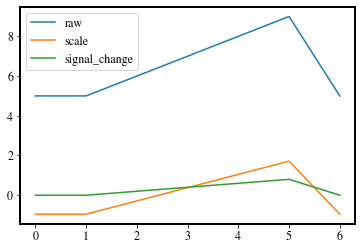

In [23]:
a = np.array([5, 5, 6, 7, 8, 9, 5])
scaler = StandardScaler()
scale_a = (a - a.mean())/a.std()
signal_change_a = (a - 5)/5

plt.plot(a, label='raw')
plt.plot(scale_a, label='scale')
plt.plot(signal_change_a, label='signal_change')
plt.legend()


#### Compute CNR based on time series

In [42]:
def get_cnr(sub_name):

    # define paths
    ciftify_dir = '/nfs/z1/userhome/ZhouMing/workingdir/BIN/action/data/bold/derivatives/ciftify'
    result_dir = 'MNINonLinear/Results/'
    # MNINolinear/Results disposit all the runs data
    _result_path = pjoin(ciftify_dir, sub_name, result_dir)
    # extract the action runs
    task = 'action' 
    data_runs = [_ for _ in os.listdir(_result_path) if ('action' in _) and (task in _) \
                    and ('discard' not in _) and int(_.split('-')[-1].split('_')[0])<=12]
    data_runs.sort() # sort() to be [1 10 11 12 2 -- 9]
    # initialize the mapping dict
    cnr_map = np.zeros((3, len(data_runs), 59412))
    # loop run
    for run_idx, single_run in enumerate(data_runs):
        print(single_run + ' in ' + sub_name)
        # prepare .feat/GrayordinatesStats dir
        nii_dir = '{0}'.format(single_run)
        nii_path = pjoin(ciftify_dir, sub_name, result_dir, nii_dir)
        # loop trial 
        nii_file = pjoin(nii_path, '{0}_Atlas.dtseries.nii'.format(single_run))
        dt_data = nib.load(nii_file).get_fdata()[:, :59412]
        # scale data
        # scaler = StandardScaler()
        # dt_data = scaler.fit_transform(dt_data)
        # locate the stimulus onset period and compute its mean form
        # In a block, stimulus present 2s and offset 2s, with 5 stimulus presenting like this, 
        # followed with a 4s blank. We will average the stimulus presenting period
        stim_time_course = dt_data[6:-6, :].reshape((12, 12, 59412)).mean(axis=0)
        # compute signal and std info
        noise_mean, noise_std = dt_data[:6, :].mean(axis=0), dt_data[:6, :].std(axis=0)
        signal_amplitude = stim_time_course.max(axis=0) - noise_mean
        signal_std = stim_time_course.std(axis=0)
        # define contrast-to-noise ratio
        # cnr_1: A/𝜎_𝑁 (signal_amplitude/noise_std)
        # cnr_2: 𝜎_𝑆/𝜎_𝑁 (signal_std/noise_std)
        cnr_1 = signal_amplitude/noise_std
        cnr_2 = signal_std/noise_std
        # merge into the containers
        cnr_map[0, run_idx] = cnr_1
        cnr_map[1, run_idx] = cnr_2
        cnr_map[2, run_idx] = noise_std
    return cnr_map.mean(axis=1)

# load data
beta_path = '/nfs/z1/zhenlab/BrainImageNet/action/data/bold/derivatives/beta'
cnr_sum = np.zeros((len(sub_names), 2, 59412))
sub_names = sorted([i for i in os.listdir(beta_path) if i.startswith('sub-') and int(i.split('-')[-1])<=30]) 

# Violin plot of the tsnr distribution
cnr_1 = np.zeros(1) #  A/𝜎_𝑁; 
cnr_2 = np.zeros(1) #  𝜎_𝑆/𝜎_𝑁;
noise_std = np.zeros(1) #  noise_std
# loop to get cnr
for sub_idx, sub_name in enumerate(sub_names):
    cnr_sub = get_cnr(sub_name)
    # concatenate data
    cnr_1 = np.concatenate((cnr_1, cnr_sub[0]), axis=0)
    cnr_2 = np.concatenate((cnr_2, cnr_sub[1]), axis=0)
    noise_std = np.concatenate((noise_std, cnr_sub[2]), axis=0)

# delete first value
cnr_1 = np.delete(cnr_1, 0, axis=0).astype(np.float32)
cnr_2 = np.delete(cnr_2, 0, axis=0).astype(np.float32)
noise_std = np.delete(noise_std, 0, axis=0).astype(np.float32)
label = np.repeat(sub_names, 59412)


ses-action01_task-action_run-1 in sub-01
ses-action01_task-action_run-10 in sub-01
ses-action01_task-action_run-11 in sub-01
ses-action01_task-action_run-12 in sub-01
ses-action01_task-action_run-2 in sub-01
ses-action01_task-action_run-3 in sub-01
ses-action01_task-action_run-4 in sub-01
ses-action01_task-action_run-5 in sub-01
ses-action01_task-action_run-6 in sub-01
ses-action01_task-action_run-7 in sub-01
ses-action01_task-action_run-8 in sub-01
ses-action01_task-action_run-9 in sub-01
ses-action01_task-action_run-1 in sub-02
ses-action01_task-action_run-10 in sub-02
ses-action01_task-action_run-11 in sub-02
ses-action01_task-action_run-12 in sub-02
ses-action01_task-action_run-2 in sub-02
ses-action01_task-action_run-3 in sub-02
ses-action01_task-action_run-4 in sub-02
ses-action01_task-action_run-5 in sub-02
ses-action01_task-action_run-6 in sub-02
ses-action01_task-action_run-7 in sub-02
ses-action01_task-action_run-8 in sub-02
ses-action01_task-action_run-9 in sub-02
ses-action

<ipython-input-43-b261b52be0ea>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_yticklabels(fig.get_yticks().astype(int), size = 15)


Text(0, 0.5, '$𝜎_𝑁$')

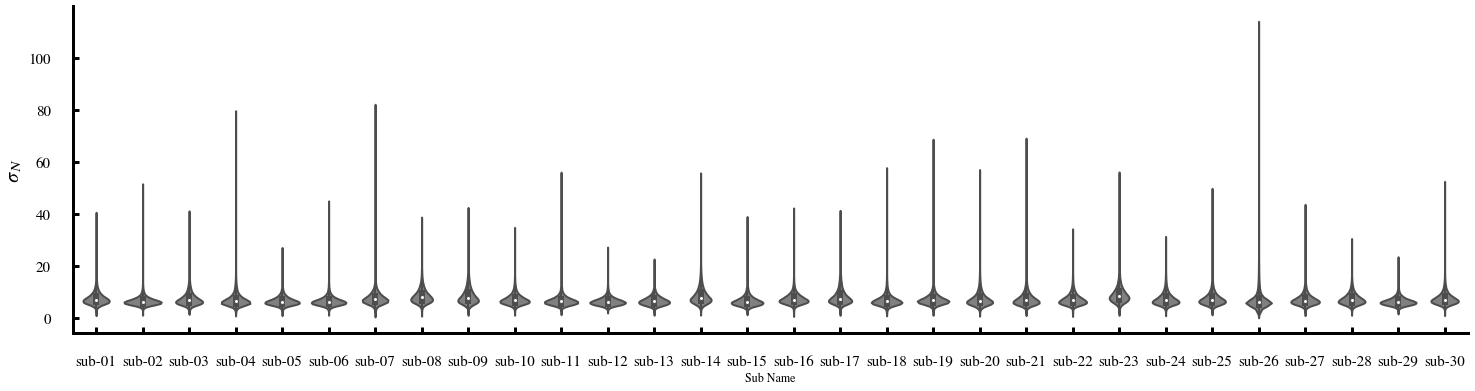

In [43]:
# merge data and label into df
df = pd.DataFrame()
df['CNR'] = noise_std
df['Sub Name'] = label
plt.figure(figsize=(25, 6))

fig = sns.violinplot(x="Sub Name", y="CNR", data=df, color='grey', linewidth=2)
fig.set_yticklabels(fig.get_yticks().astype(int), size = 15)
ax = plt.gca()

ax.tick_params(labelsize=15, width=3, length=6, direction="in", pad=22)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
plt.ylabel(f'$𝜎_𝑁$', size = 20)

#### Compute CNR based on GLM model
#### CNR = A/𝜎_𝑁  or  CNR = 𝜎_𝑆/𝜎_𝑁
##### 𝜎_𝑁 refers the noise std, it corresponds to std of the residual of the model fit
##### 𝜎_𝑆 refers the signal std, it corresponds to std of the predicted time series from the GLM model
##### A refers the stimulus induced activation amplitude, it corresponds to GLM model beta with multiplying the HRF height




In [5]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
from sklearn.linear_model import Ridge
from os.path import join as pjoin
from nilearn.glm.first_level import make_first_level_design_matrix
from sklearn.linear_model import LinearRegression

# generate surface map for tSNR
def save_ciftifile(data, filename):
    template = '/nfs/z1/zhenlab/BrainImageNet/NaturalObject/data/bold/Analysis_derivatives/ciftify/sub-core02/MNINonLinear/Results/ses-ImageNet01_task-object_run-1/ses-ImageNet01_task-object_run-1_Atlas.dtseries.nii'
    ex_cii = nib.load(template)
    if len(data.shape) > 1:
        ex_cii.header.get_index_map(0).number_of_series_points = data.shape[0]
    else:
        ex_cii.header.get_index_map(0).number_of_series_points = 1
        data = data[np.newaxis, :]
    nib.save(nib.Cifti2Image(data.astype(np.float32), ex_cii.header), filename)

# define path
beta_path = '/nfs/z1/zhenlab/BrainImageNet/action/data/bold/derivatives/beta'
ciftify_path = '/nfs/z1/zhenlab/BrainImageNet/action/data/bold/derivatives/ciftify'
nifti_path = '/nfs/z1/zhenlab/BrainImageNet/action/data/bold/nifti'
result_path = '/nfs/z1/userhome/ZhouMing/workingdir/BIN/action/utils/HAD/result/brain_map'

# prepare params
# sub_names = sorted([i for i in os.listdir(beta_path) if i.startswith('sub') and int(i.split('-')[-1])<=30])
sub_names = ['sub-19']

cnr_sum = np.zeros((len(sub_names), 2, 59412)) # 2 refers to the different cnr calculation methods. 0 refers sigma and 1 refers amplitude
for sub_idx, sub_name in enumerate(sub_names):
    # prepare basic path
    cnr_path = pjoin(beta_path, sub_name, f'{sub_name}_action-cnr.npy')
    if os.path.exists(cnr_path):
        # prepare params
        tr, begin_dur, n_tr, n_event, n_run, n_class = 2, 12, 156, 60, 12, 4
        frame_times = np.arange(n_tr) * tr 
        # define beta path
        sub_tmp_path = pjoin(nifti_path, sub_name)
        _result_path = pjoin(ciftify_path, sub_name, 'MNINonLinear/Results/')
        sess_name = 'ses-action01'
        beta_clean = np.zeros((n_class, 59412), dtype=np.float32)
        # loop in one subject
        sub_func_path = pjoin(sub_tmp_path, sess_name, 'func')
        events_file = sorted([i for i in os.listdir(sub_func_path) if 'events' in i and 'rest' not in i and \
                            int(i.split('-')[-1].split('_')[0])<=12 and 'discard' not in i])
        cnr_sub = np.zeros((len(events_file), 2, 59412)) # 2 refers to the different cnr calculation methods. 0 refers sigma and 1 refers amplitude
        for run_idx, file in enumerate(events_file): 
            # define run name
            run_split = file.split('_')
            run_name = '_'.join(run_split[1:3]) + '_run-' + str(int(run_split[3].split('-')[-1]))
            # fit design matrix based on trial onset time
            events_raw = pd.read_csv(pjoin(sub_func_path, file), sep='\t')
            duration = events_raw['duration']
            onset = events_raw['onset'].to_numpy() + begin_dur
            label_tmp = events_raw['trial_type'].to_numpy()
            # for active versus baseline 
            trial_type = np.repeat('active', n_event)
            # for different class comparision
            # trial_type = ['image%03d'%idx for idx in label_tmp]
            # load time series
            dtseries_path = pjoin(_result_path, run_name, f'{run_name}_Atlas.dtseries.nii')
            dtseries = nib.load(dtseries_path).get_fdata()
            # print(f'load {dtseries_path}')
            # prepare design matrix
            events = pd.DataFrame({'trial_type':trial_type, 'onset':onset, 'duration':duration})
            design_matrix = make_first_level_design_matrix(frame_times, events, drift_model=None, hrf_model='spm')
            design_matrix.drop(design_matrix.columns[-1], axis=1, inplace=True)
            # height of hrf
            hrf_height = design_matrix.to_numpy()[:, 0].max()
            # add drift columns
            drift_order = 2
            frame_times_single = np.arange(n_tr) * tr 
            drift_effect = np.zeros((n_tr, drift_order+1))
            tmax = float(frame_times_single.max())
            for k in range(drift_order+1):
                drift_effect[:, k] = (frame_times_single / tmax) ** k
            drift_effect = pd.DataFrame(drift_effect)
            # concantenate 
            design_matrix = pd.concat([design_matrix.reset_index(drop=True), drift_effect], ignore_index=True, axis=1)  
            # fit GLM model and get predicted time series and residual
            reg = LinearRegression(fit_intercept=False).fit(design_matrix.values, dtseries[:, :59412])
            beta_clean = reg.coef_[:, :n_class].transpose(1,0).astype(np.float32)
            time_series_predicted = np.dot(design_matrix, beta_clean)
            residual = dtseries[:, :59412] - time_series_predicted
            # compute CNR: A/𝜎_𝑁 or 𝜎_𝑆/𝜎_𝑁
            sigma_noise = residual.std(axis=0)
            sigma_signal = time_series_predicted.std(axis=0)
            amplitude = beta_clean[0] * hrf_height
            cnr_sigma = sigma_signal/sigma_noise
            cnr_amplitude = amplitude/sigma_noise
            cnr_sub[run_idx, 0] = cnr_sigma
            cnr_sub[run_idx, 1] = cnr_amplitude
            # print('Finish computing CNR in %s %s %s'%(sub_name, sess_name, run_name))
        cnr_sub = cnr_sub.mean(axis=0)
        # save data
        np.save(cnr_path, cnr_sub.astype(np.float32))
    else:
        cnr_sub = np.load(cnr_path)
        print('CNR Mean in %s: %.2f'%(sub_name, cnr_sub[1, :].mean()))
    # merge cnr into containers
    cnr_sum[sub_idx] = cnr_sub
cnr_sum = cnr_sum.mean(axis=0)
print('CNR Mean in All Subjects: %.2f'%(cnr_sum[1, :].mean()))

# order = ['sigma', 'amplitude']
# for idx in range(2):
#     cnr_map = np.zeros((91282))
#     cnr_map[:59412] = cnr_sum[idx]
#     save_ciftifile(cnr_map, pjoin(result_path, f'cnr_{order[idx]}.dtseries.nii'))


CNR Mean in All Subjects: 0.00


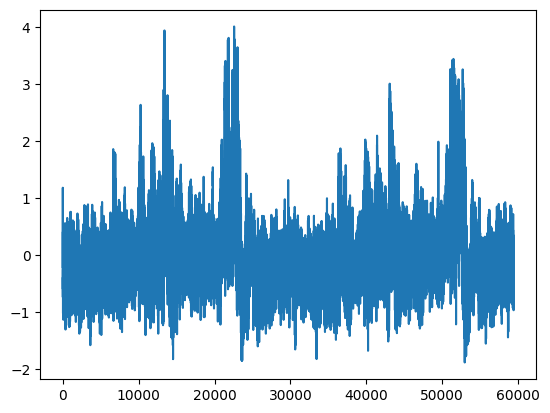

In [6]:
import matplotlib.pyplot as plt

plt.plot(cnr_amplitude)


In [7]:
cnr_map = np.zeros((91282))
cnr_map[:59412] = cnr_sum[1]
save_ciftifile(cnr_map, pjoin(result_path, f'cnr_sub_19.dtseries.nii'))

In [4]:
cnr_sub[1].mean()

0.07305134

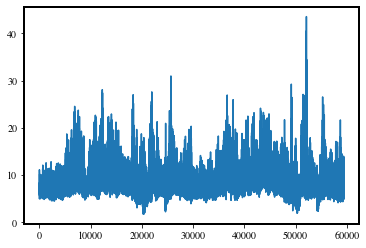

In [5]:
plt.plot(sigma_noise)

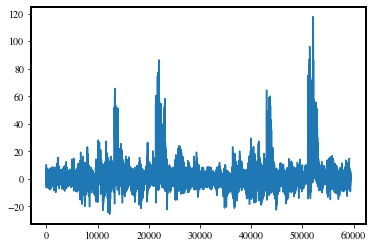

In [7]:
plt.plot(amplitude)

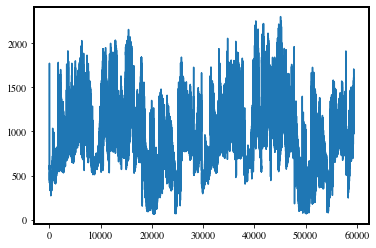

In [9]:
plt.plot(beta_clean[1])

1.6344614207744597
0.05239754477515817
0.32063715159893036


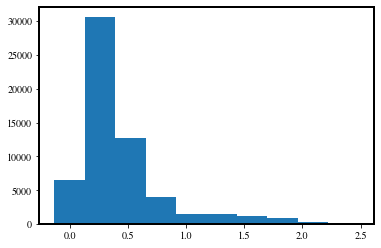

In [2]:
cnr_amplitude = nib.load('/nfs/z1/userhome/ZhouMing/workingdir/BIN/action/utils/HAD/result/brain_map/cnr_amplitude.dtseries.nii').get_fdata()
cnr_amplitude = np.array(cnr_amplitude)[0, :59412]

thresh = 1
plt.hist(cnr_amplitude)
print(np.percentile(cnr_amplitude, 97.5))
print(np.percentile(cnr_amplitude, 2.5))
print(np.percentile(cnr_amplitude, 50))

0.060105702551673065
0.13313183209368187
2.2960134235796663


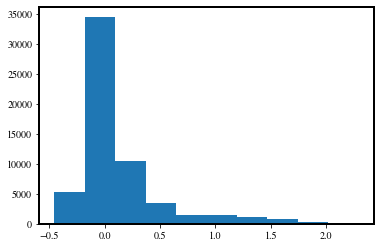

In [10]:
thresh = 1
cnr_amplitude = cnr_sum[1]
plt.hist(cnr_amplitude)
print((cnr_amplitude>thresh).sum()/cnr_amplitude.shape[0])
print(cnr_amplitude.mean())
print(cnr_amplitude.max())

#### Plot CNR distribution in different networks

In [3]:
# define path
main_path = '/nfs/z1/zhenlab/BrainImageNet/Analysis_results/'
network_path = '/nfs/z1/atlas/ColeAnticevicNetPartition'
roi_name_path = pjoin(main_path, 'roilbl_mmp.csv')
roi_path = pjoin(main_path, 'MMP_mpmLR32k.mat')

# load network partition info
roi = sio.loadmat(roi_path)['glasser_MMP']
roi_names = pd.read_csv(roi_name_path)
network = sio.loadmat(pjoin(network_path, 'cortex_parcel_network_assignments.mat'))['netassignments'] 
network = [x[0] for x in network]

# obtain network name
with open(pjoin(network_path, 'network_labelfile.txt'), 'r') as f:
    text = f.readlines()
network_names = [x.strip('\n') for x in text if not x[0].isdigit()]
network_order = [int(x.split(' ')[0].strip('\n')) for x in text if x[0].isdigit()]

# transform network name order for better plotting
network_names_refine = ['Primary Visual', 'Secondary Visual', 'Ventral Multimodal', 'Posterior Multimodal', 'Somatomotor', 'Dorsal-attention',
                        'Cingulo-Opercular', 'Language', 'Default', 'Frontoparietal', 'Auditory', 'Orbito-Affective']
network_order_refine = [network_order[network_names.index(x)] for x in network_names_refine]

# extract target cnr value
cnr_amplitude = cnr_sum[1]
network_partition = np.zeros(59412)
for loop_idx, network_idx in enumerate(network_order_refine):
    network_name = network_names_refine[loop_idx]
    roi_index = [idx+1 for idx,x in enumerate(network) if x in [network_idx]]
    voxel_selected = np.asarray([True if x in roi_index else False for x in roi[0]])
    network_partition[voxel_selected] = loop_idx+1
    print('%05d voxels in %s'%(voxel_selected.sum(), network_name))


02138 voxels in Primary Visual
06817 voxels in Secondary Visual
01139 voxels in Ventral Multimodal
00937 voxels in Posterior Multimodal
10011 voxels in Somatomotor
03810 voxels in Dorsal-attention
09152 voxels in Cingulo-Opercular
03332 voxels in Language
11598 voxels in Default
08099 voxels in Frontoparietal
01664 voxels in Auditory
00715 voxels in Orbito-Affective


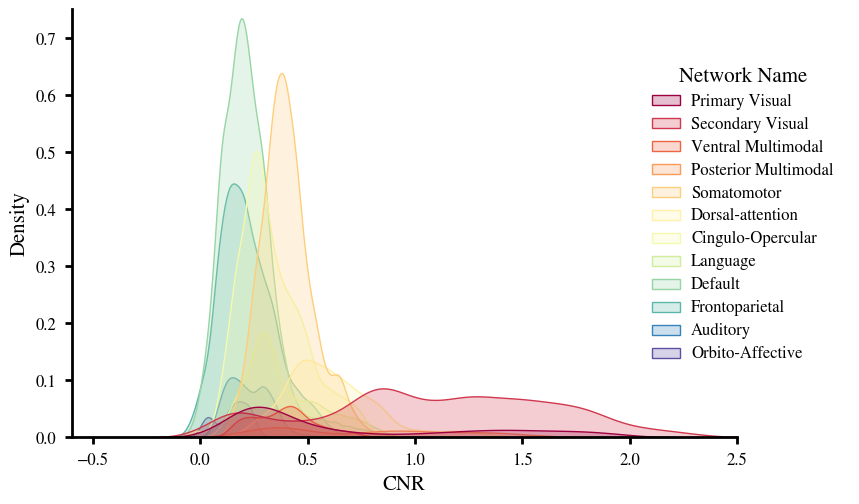

In [5]:
import seaborn as sns

sns.reset_orig()
# sns.set_style(style='white')
# sns.set(font="STIXGeneral")
mpl.rcParams['font.family'] = 'STIXGeneral'

# make cnr dataframe
cnr_info = pd.DataFrame(np.concatenate((cnr_amplitude[:, np.newaxis], network_partition[:, np.newaxis]), axis=1), columns=['cnr', 'Network Name'])
# distribution plot
ax = sns.displot(data=cnr_info, x='cnr', hue='Network Name', kind='kde', 
                 fill=True, height=5, aspect=1.5, palette=sns.color_palette('Spectral', as_cmap=True))

# for legend text
for t, l in zip(ax._legend.texts, network_names_refine):
    t.set_text(l)
plt.setp(ax._legend.get_texts(), fontsize='12') 
plt.setp(ax._legend.get_title(), fontsize='15') 
ax._legend.set_bbox_to_anchor((1, 0.58)) # left → right, down → up

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.xlabel('CNR', fontsize=15)
plt.ylabel('Density', fontsize=15)
ax = plt.gca()
ax.tick_params(labelsize=12, width=2, length=5, direction="out", pad=6)
ax.set_xlim(-0.6, 2.5)
ax.set_ylim(0, 0.75)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)


In [5]:
# extract target cnr value
cnr_amplitude = cnr_sum[1]

# Iterate to discover the high CNR ROI
main_path = '/nfs/z1/zhenlab/BrainImageNet/Analysis_results/'
utils_path = '/nfs/z1/userhome/ZhouMing/workingdir/BIN/action/utils/HAD/data/utils'
roi_name_path = pjoin(main_path, 'roilbl_mmp.csv')
roi_names = pd.read_csv(roi_name_path).iloc[:, 0].tolist()

roi_assign = pd.read_csv(pjoin(utils_path, 'HCP-MMP1_visual-cortex2.csv'))
# Primary_Visual and Early_Visual
EV_name = roi_assign.loc[roi_assign['ID_in_22Region'].isin([1, 2]), 'area_name'].to_list()
# Ventral_Stream_Visual and Medial_Temporal
VS_name = roi_assign.loc[roi_assign['ID_in_22Region'].isin([4, 13, 14]), 'area_name'].to_list()
# MT+_Complex, Dorsal_Stream_Visual, Superior_Parietal, Inferior_Parietal and Posterior_Cingulate
DS_name = roi_assign.loc[roi_assign['ID_in_22Region'].isin([3, 5, 16, 17, 18]), 'area_name'].to_list()

roi_target = {'Early':EV_name, 'Ventral':VS_name, 'Dorsal':DS_name}

cnr_value, cnr_label = [], []
for region_idx, region in enumerate(roi_target.keys()):
    roi_sum = roi_mask(roi_target[region])
    tmp_cnr = cnr_amplitude[roi_sum]
    tmp_labels = np.repeat(region, roi_sum.sum())
    # save in containers
    cnr_value.extend(tmp_cnr)
    cnr_label.extend(tmp_labels)
    print(f'Finish {region}')


Finish Early
Finish Ventral
Finish Dorsal


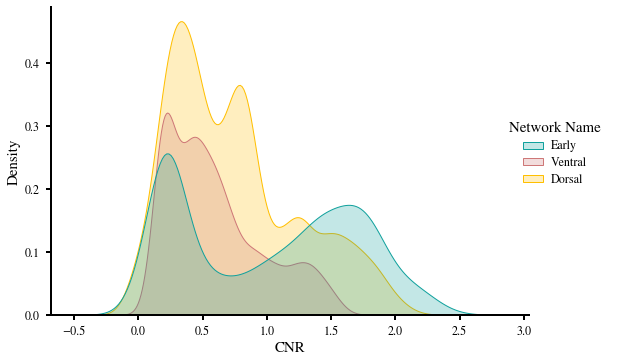

In [6]:
import seaborn as sns

sns.reset_orig()
# sns.set_style(style='white')
# sns.set(font="STIXGeneral")
mpl.rcParams['font.family'] = 'STIXGeneral'
colors = ['#10A19D', '#CE7777', '#FFBF00']

# make cnr dataframe
cnr_info = pd.DataFrame({'cnr':cnr_value, 'Network Name':cnr_label})

# distribution plot
ax = sns.displot(data=cnr_info, x='cnr', hue='Network Name', kind='kde', palette=sns.color_palette(colors),
        fill=True, height=5, aspect=1.5)

# for legend text
for t, l in zip(ax._legend.texts, roi_target.keys()):
    t.set_text(l)
plt.setp(ax._legend.get_texts(), fontsize='12') 
plt.setp(ax._legend.get_title(), fontsize='15') 
ax._legend.set_bbox_to_anchor((1, 0.58)) # left → right, down → up

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.xlabel('CNR', fontsize=15)
plt.ylabel('Density', fontsize=15)
ax = plt.gca()
ax.tick_params(labelsize=12, width=2, length=5, direction="out", pad=6)
# ax.set_xlim(-0.6, 2.5)
# ax.set_ylim(0, 0.75)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)


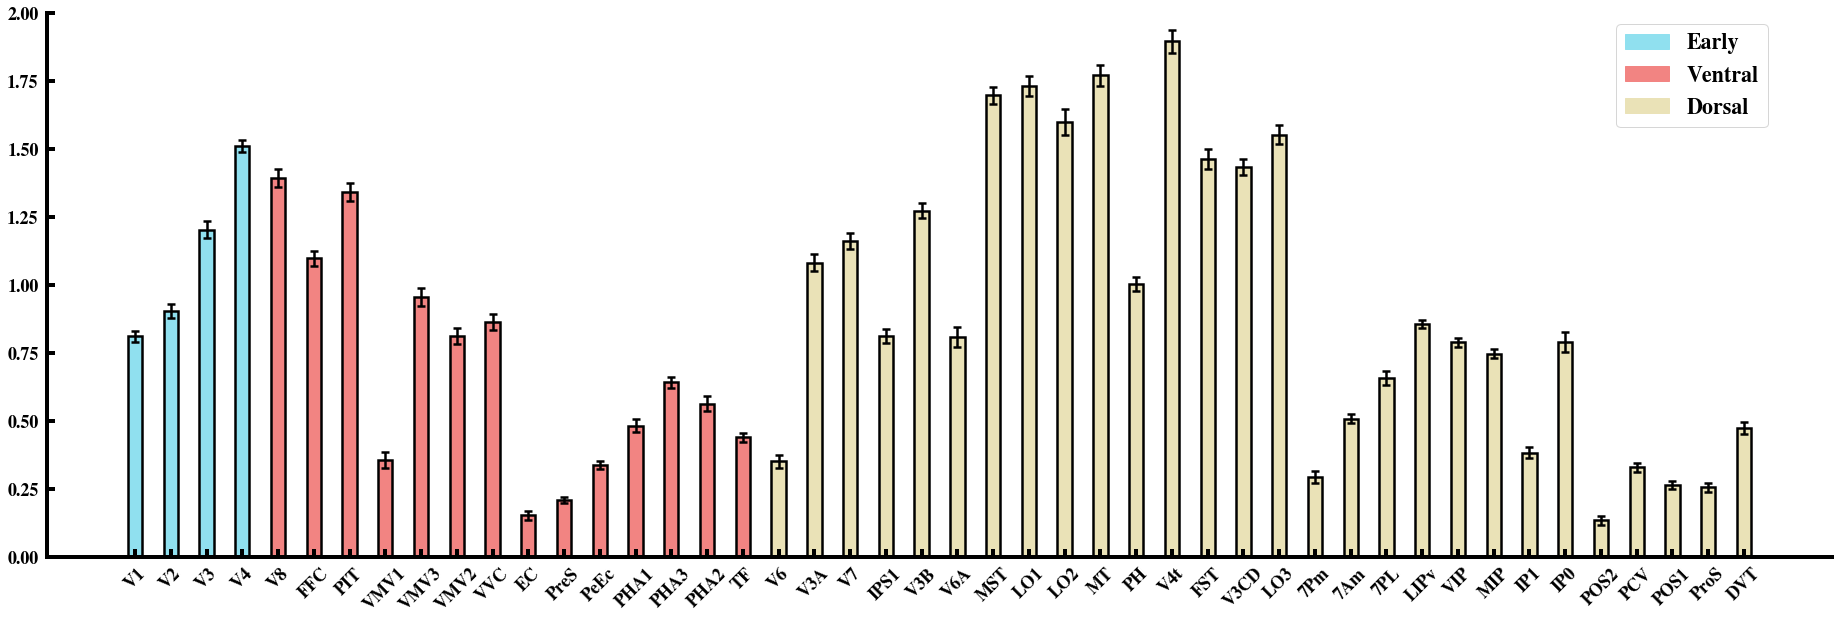

In [10]:
import matplotlib.patches as mpatches

# Iterate to discover the high CNR ROI
main_path = '/nfs/z1/zhenlab/BrainImageNet/Analysis_results/'
utils_path = '/nfs/z1/userhome/ZhouMing/workingdir/BIN/action/utils/HAD/data/utils'
roi_name_path = pjoin(main_path, 'roilbl_mmp.csv')
roi_names = pd.read_csv(roi_name_path).iloc[:, 0].tolist()

roi_assign = pd.read_csv(pjoin(utils_path, 'HCP-MMP1_visual-cortex2.csv'))
# Primary_Visual and Early_Visual
EV_name = roi_assign.loc[roi_assign['ID_in_22Region'].isin([1, 2]), 'area_name'].to_list()
# Ventral_Stream_Visual and Medial_Temporal
VS_name = roi_assign.loc[roi_assign['ID_in_22Region'].isin([4, 13, 14]), 'area_name'].to_list()
# MT+_Complex, Dorsal_Stream_Visual, Superior_Parietal, Inferior_Parietal and Posterior_Cingulate
DS_name = roi_assign.loc[roi_assign['ID_in_22Region'].isin([3, 5, 16, 17, 18]), 'area_name'].to_list()

roi_target = {'Early':EV_name, 'Ventral':VS_name, 'Dorsal':DS_name}
n_roi = len([*EV_name, *VS_name, *DS_name])

cnr_roi = np.zeros((2, n_roi))
colors_region = ['#90e0ef', '#f28482', '#eae2b7']
roi_idx, labels, colors = 0, [], []
for region_idx, region in enumerate(roi_target.keys()):
    roi_sum = roi_target[region]
    colors.extend([colors_region[region_idx] for x in range(len(roi_sum))])
    for roi in roi_sum:
        tmp_mask = roi_mask(roi)
        cnr_roi[0, roi_idx] = cnr_amplitude[tmp_mask].mean()
        cnr_roi[1, roi_idx] = np.sqrt(cnr_amplitude[tmp_mask].std()/tmp_mask.sum())
        roi_idx += 1
        labels.append(roi)

width = 0.2
x_1 = 0.5*np.arange(len(labels))

plt.figure(figsize=(32, 10))
plt.bar(x_1, cnr_roi[0], yerr=cnr_roi[1], color=colors, 
        width=width, edgecolor='black', linewidth=2.5, error_kw=dict(lw=2.5, capsize=4, capthick=2.5), ecolor = "black")

# manually add color legend
handles = []
for region_idx, region in enumerate(roi_target.keys()):
    handles.append(mpatches.Patch(color=colors_region[region_idx], label=region))
plt.legend(handles=handles, bbox_to_anchor = (0.97, 1), prop={'size':22, 'weight':'bold'})

# Add some text for labels, title and custom x-axis tick labels, etc.
ax = plt.gca()
# ax.set_ylabel('Pattern Correlation', weight='bold', size=20, label)
ax.tick_params(labelsize=18, width=4, length=8, direction="in", pad=8)
plt.xticks(x_1, labels, weight='bold', fontsize=18, rotation=45)
plt.yticks(weight='bold')
ax.set_ylim(0, 2)
# ax.set_xlim(-0.5, 2.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(4)
# ax.spines['bottom'].set_position(('data', 0.9))
ax.spines['left'].set_linewidth(4)


#### Demonstrated the high-quality regions of interest (ROI) whose mean CNR value across voxels were outside of 95% in the whole distribution (CNR>1.34)

In [7]:
def roi_mask(roi_name):
    """
        roi_name : list or str
    """
    # load reference info
    main_path = '/nfs/z1/zhenlab/BrainImageNet/Analysis_results/'
    roi_name_path = pjoin(main_path, 'roilbl_mmp.csv')
    roi_names = pd.read_csv(roi_name_path)
    roi = sio.loadmat(pjoin(main_path, 'MMP_mpmLR32k.mat'))['glasser_MMP']  # 1x59412

    # start load name
    roi_index = []
    if isinstance(roi_name, str):
        roi_tmp_index = roi_names.loc[roi_names.isin([f'L_{roi_name}_ROI']).any(axis=1)].index[0]+1
        roi_index.extend([roi_tmp_index, roi_tmp_index+180])
        mask = np.asarray([True if x in roi_index else False for x in roi[0]])
    else:
        for name in roi_name:
            roi_tmp_index = roi_names.loc[roi_names.isin([f'L_{name}_ROI']).any(axis=1)].index[0]+1
            roi_index.extend([roi_tmp_index, roi_tmp_index+180])
        mask = np.asarray([True if x in roi_index else False for x in roi[0]])
    return mask

# define threshold
cnr_amplitude = cnr_sum[1]
cnr_thresh = np.percentile(cnr_amplitude, 95)

# Iterate to discover the high CNR ROI
main_path = '/nfs/z1/zhenlab/BrainImageNet/Analysis_results/'
roi_name_path = pjoin(main_path, 'roilbl_mmp.csv')
roi_names = pd.read_csv(roi_name_path).iloc[:, 0].tolist()

roi_target, roi_target_cnr = [], np.zeros((1, 2))
for roi_name in roi_names:
    roi_name = roi_name.split('_')[1]
    mask = roi_mask(roi_name)
    cnr_value = cnr_amplitude[mask].mean()
    if cnr_value > cnr_thresh:
        roi_target.append(roi_name)
        tmp_value = np.array([cnr_amplitude[mask].mean(), np.sqrt(cnr_amplitude[mask].std()/mask.sum())])
        roi_target_cnr = np.concatenate((roi_target_cnr, tmp_value[np.newaxis, :]), axis=0)
        print('Find %s with CNR value: %.2f'%(roi_name, cnr_value))
roi_target_cnr = np.delete(roi_target_cnr, 0, axis=0)


Find MST with CNR value: 1.70
Find V4 with CNR value: 1.51
Find V8 with CNR value: 1.40
Find LO1 with CNR value: 1.73
Find LO2 with CNR value: 1.60
Find MT with CNR value: 1.77
Find V4t with CNR value: 1.90
Find FST with CNR value: 1.46
Find V3CD with CNR value: 1.44
Find LO3 with CNR value: 1.55


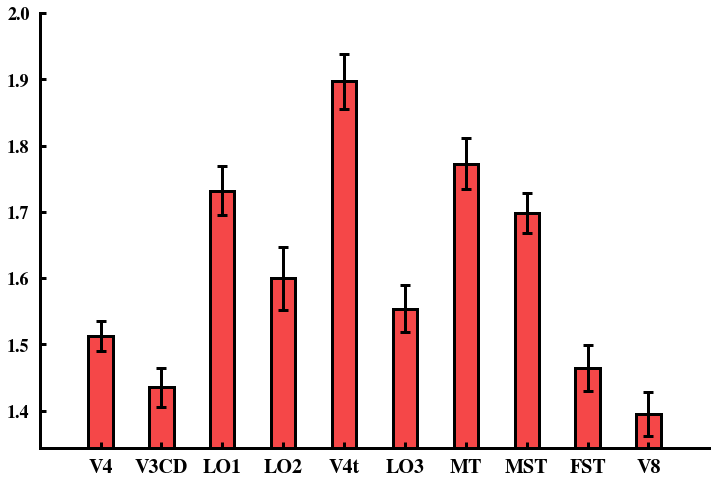

In [11]:
# rearange the label
labels = ['V4', 'V3CD', 'LO1', 'LO2', 'V4t', 'LO3', 'MT', 'MST', 'FST', 'V8']
label_new_idx = [roi_target.index(label) for label in labels]
roi_target_cnr = roi_target_cnr[label_new_idx]

# bar plot
width = 0.2
x_1 = 0.5*np.arange(len(roi_target))

plt.figure(figsize=(12, 8))
plt.bar(x_1, roi_target_cnr[:, 0], yerr=roi_target_cnr[:, 1], color='#F54748', 
        width=width, edgecolor='black', linewidth=3, error_kw=dict(lw=3, capsize=5, capthick=3), ecolor = "black")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax = plt.gca()
# ax.set_ylabel('Pattern Correlation', weight='bold', size=20, label)
ax.tick_params(labelsize=18, width=3, length=6, direction="in", pad=10)

plt.xticks(x_1, labels, weight='bold', fontsize=20)
plt.yticks(weight='bold')
# plt.legend(loc='upper left', prop={'size':16, 'weight':'bold'})
ax.set_ylim(cnr_thresh, 2)
ax.set_xlim(-0.5, 5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
# ax.spines['bottom'].set_position(('data', 0.9))
ax.spines['left'].set_linewidth(3)